In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors



from itertools import combinations
import scipy
from scipy.ndimage.filters import gaussian_filter1d
import sys
import os
import copy
atish_assay_path = 'fitness_assay_grantedits.py'
sys.path.append(os.path.dirname(os.path.expanduser(atish_assay_path)))
import fitness_assay_grantedits as atish

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

In [3]:
def jitter_point(mean,std=0.15):
    return np.random.normal(mean,std)

In [4]:
name = 'noF_DoubleBC_merged+flaskswapcorrected_032119'

merged_data = p.read_csv(f'../data/BarcodeCounts_{name}.csv')


print(np.sum(merged_data[[col for col in merged_data.columns if 'A' in col ]]))

### Remove Ancestor (bcs 9999999 (with restriction site) and 7777777 (without res. site))
# merged_data = merged_data[~(merged_data['barcode'].isin([7777777,9999999]))]

print(np.sum(merged_data[[col for col in merged_data.columns if 'A' in col ]]))

A0     22909011.0
A1     18597988.0
A2     28275282.0
A3      2040383.0
A4      7188157.0
AA0     5692854.0
AA1     3681445.0
AA2     6604506.0
AA3      533088.0
AA4      839246.0
dtype: float64
A0     22909011.0
A1     18597988.0
A2     28275282.0
A3      2040383.0
A4      7188157.0
AA0     5692854.0
AA1     3681445.0
AA2     6604506.0
AA3      533088.0
AA4      839246.0
dtype: float64


In [5]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_0.2MNaCl' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }



conditions = {**old_conditions, **bigbatch_conditions}

just_reps = [rep for reps in conditions.values() for rep in reps]

In [10]:
data = merged_data
data = data[~(data['barcode'].isin([7777777,9999999]))]
data = data.sort_values('barcode')

cov_thresh = 100

### called neutral by atish's method in ALL 5000 bc experiments (I think - need to verify this)
### [could also be below some set threshold across all experiments]
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

neutrals = [bc for bc in data['barcode'].values if bc in neutrals]
# neutrals = neutral_spikes
print(neutrals)

fitnesses = {}



for condition,replicates in conditions.items():
    print(condition)
    print(replicates)
    rep_times = {}
    for rep in replicates:
        
        these_times = []
        timepoints = []
        if condition in old_conditions.keys():
            
            e,r = rep.split('.')
    #         if e in ['13','15']:
    #             timepoints.append(0)
    #             these_times.append('13-0_pool')
    #         else:
    #             if e+'-0' in data.columns:
    #                 timepoints.append(0)
    #                 these_times.append(e+'-0')
            for t in range(5):
                if e+'-'+str(t)+'-'+r in data.columns:
                    timepoints.append(t)
                    these_times.append(e+'-'+str(t)+'-'+r)

        if condition in bigbatch_conditions.keys():
            for i in range(5):
                if rep+str(i) in data.columns:
                    these_times.append(rep+str(i))
                    timepoints.append(i)
        rep_times[rep] = data[these_times].values
        print(timepoints)
    answer = atish.inferFitness(data['barcode'].values,timepoints,rep_times,
                                neutralBarcodes=neutrals,lowCoverageThresh=cov_thresh,use_all_neutral=True,useMultNoise=True)


    for rep in replicates:

        fitnesses[rep+'_fitness'] = answer[rep]['aveFitness']
        fitnesses[rep+'_error'] = answer[rep]['aveError']

for other_setting in ['barcode','gene','ploidy','class','type']:
    if other_setting in data.columns:
        fitnesses[other_setting] = data[other_setting].values

fitness_df = p.DataFrame(fitnesses)
# fitness_df = fitness_df[~np.isfinite(fitness_df)] = np.nan
# fitness_df = fitness_df.replace([float('Inf'),-float('Inf'),np.inf, -np.inf], np.nan)

# for condition,replicates in conditions.items():
    
    
#     fitness_df[condition+'_fitness'] = np.nansum([fitness_df[rep+'_fitness'].values/fitness_df[rep+'_error'].values for rep in replicates],axis=0) \
#     /np.nansum([1.0/fitness_df[rep+'_error'].values for rep in replicates],axis=0)
    
#     fitness_df[condition+'_error'] = np.nansum([1.0/fitness_df[rep+'_error'].values for rep in replicates],axis=0)**(-1)


# fitness_df.to_csv('../data/DoubleBC_Merged_Fitness_Atish_Default_AllConditions_AdditiveNoiseOnly.csv',index=False)


[17615, 24362, 42040, 71926, 72939, 73802, 109476, 113483, 120600, 134852, 263665, 298344, 316954]
3
['3.1', '3.2', '3.3']
[1, 2, 3, 4]
[1, 2, 3, 4]
[1, 2, 3, 4]
neutral reads 2880.0 1653.0
neutral reads 1653.0 557.0
neutral reads 557.0 391.0
neutral reads 2880.0 1653.0
neutral reads 1653.0 557.0
neutral reads 557.0 391.0
neutral reads 3939.0 1558.0
neutral reads 1558.0 782.0
neutral reads 782.0 284.0
neutral reads 3939.0 1558.0
neutral reads 1558.0 782.0
neutral reads 782.0 284.0
neutral reads 3368.0 1959.0
neutral reads 1959.0 776.0
neutral reads 776.0 430.0
neutral reads 3368.0 1959.0
neutral reads 1959.0 776.0
neutral reads 776.0 430.0
Multiplicative noise consistency checks

3.1  inconsistent times:

kappas [1.7437897  2.31538368 1.81788505]
multNoise [0.11285201 0.11902568 0.10235688]
No clear inconsistencies


3.2  inconsistent times:

kappas [4.73791928 5.1001428  1.46530054]
multNoise [0.11285201 0.11902568 0.10235688]
No clear inconsistencies


3.3  inconsistent times:

kappa

/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:218: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:218: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:385: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:385: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_a

neutral reads 49279.0 47984.0
neutral reads 47984.0 44600.0
neutral reads 44600.0 2206.0
neutral reads 2206.0 5463.0
neutral reads 49279.0 47984.0
neutral reads 47984.0 44600.0
neutral reads 44600.0 2206.0
neutral reads 2206.0 5463.0
neutral reads 163396.0 20159.0
neutral reads 20159.0 89144.0
neutral reads 89144.0 41341.0
neutral reads 41341.0 50223.0
neutral reads 163396.0 20159.0
neutral reads 20159.0 89144.0
neutral reads 89144.0 41341.0
neutral reads 41341.0 50223.0
neutral reads 22513.0 60230.0
neutral reads 60230.0 78877.0
neutral reads 78877.0 7367.0
neutral reads 7367.0 26379.0
neutral reads 22513.0 60230.0
neutral reads 60230.0 78877.0
neutral reads 78877.0 7367.0
neutral reads 7367.0 26379.0
neutral reads 30234.0 41324.0
neutral reads 41324.0 15145.0
neutral reads 15145.0 10807.0
neutral reads 10807.0 5803.0
neutral reads 30234.0 41324.0
neutral reads 41324.0 15145.0
neutral reads 15145.0 10807.0
neutral reads 10807.0 5803.0
Multiplicative noise consistency checks

A  incons

In [13]:
merged_data

,13-0,13-0_pool,13-1-1,13-1-2,13-1-3,13-2-1,13-2-2,13-2-3,13-3-1,13-3-2,...,Y1,Y2,Y3,Y4,Z0,Z1,Z2,Z3,Z4,barcode
0,2.0,10.0,512.0,700.0,594.0,594.0,403.0,104.0,319.0,299.0,...,1263.0,5496.0,2243.0,786.0,535.0,1103.0,281.0,15.0,128.0,53
1,2625.0,3914.0,43106.0,54385.0,42068.0,160273.0,107883.0,20536.0,399304.0,308884.0,...,86131.0,1073318.0,1056267.0,562172.0,15967.0,108918.0,67856.0,3506.0,184186.0,151
2,15.0,46.0,2909.0,2977.0,2776.0,2582.0,1640.0,442.0,1524.0,1028.0,...,956.0,3214.0,1366.0,413.0,351.0,914.0,119.0,6.0,111.0,262
3,710.0,1187.0,36510.0,32361.0,30864.0,92924.0,59293.0,14493.0,149876.0,114393.0,...,22251.0,228659.0,166093.0,78766.0,5738.0,29997.0,21563.0,935.0,26450.0,273
4,373.0,631.0,21956.0,23483.0,22294.0,46277.0,33707.0,7626.0,79897.0,57846.0,...,9308.0,69827.0,49628.0,17444.0,1970.0,10486.0,3452.0,163.0,6759.0,323
5,88.0,165.0,2745.0,4386.0,3120.0,7695.0,7096.0,1194.0,17769.0,18873.0,...,35411.0,488570.0,449553.0,170567.0,4252.0,32531.0,26118.0,1540.0,36814.0,415
6,48.0,104.0,2335.0,3792.0,3057.0,5985.0,5549.0,1073.0,10823.0,10856.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,499
7,0.0,3.0,64.0,57.0,65.0,81.0,27.0,7.0,34.0,23.0,...,901.0,3846.0,1619.0,474.0,365.0,464.0,122.0,9.0,81.0,622
8,170.0,278.0,5462.0,7846.0,6551.0,15647.0,11789.0,1937.0,28198.0,27943.0,...,11231.0,158367.0,155288.0,69505.0,1221.0,8717.0,10034.0,646.0,14755.0,689
9,6.0,5.0,937.0,1094.0,910.0,936.0,601.0,141.0,581.0,397.0,...,1036.0,4766.0,1868.0,580.0,373.0,676.0,204.0,5.0,96.0,697


In [11]:
fitness_df.replace([np.inf, -np.inf], np.nan).dropna()

,13.1_error,13.1_fitness,13.2_error,13.2_fitness,13.3_error,13.3_fitness,18.1_error,18.1_fitness,18.2_error,18.2_fitness,...,J_fitness,O_error,O_fitness,P_error,P_fitness,Y_error,Y_fitness,Z_error,Z_fitness,barcode
0,0.086877,0.366047,0.083404,0.315150,0.089447,0.179195,0.085672,0.348879,0.102501,0.402902,...,0.394319,0.054619,0.517133,0.059401,0.281774,0.116600,0.106013,0.124976,0.057761,53
1,0.059241,1.628226,0.059251,1.570717,0.059331,1.338887,0.071395,1.032191,0.071416,1.293255,...,1.087407,0.050905,0.252553,0.103433,-2.547008,0.101087,0.847314,0.100930,1.132521,151
3,0.059303,1.133521,0.059304,1.206520,0.059408,0.950879,0.071422,0.853977,0.071473,0.972209,...,0.885406,0.051479,0.425995,0.081520,-1.036554,0.101969,0.593182,0.101362,0.873284,273
4,0.059382,1.113742,0.059383,1.101149,0.059592,0.762177,0.071486,0.885550,0.071566,0.907004,...,0.693999,0.052638,0.421169,0.070879,-0.430072,0.103552,0.548694,0.102811,0.852232,323
5,0.060026,1.328568,0.059880,1.330132,0.061292,0.992309,0.071963,1.017761,0.072488,1.113563,...,0.966842,0.062332,-0.290556,0.218403,-3.652083,0.101529,0.839994,0.101279,1.099136,415
8,0.059639,1.351715,0.059628,1.287908,0.060450,1.001588,0.071751,0.994354,0.071986,1.105001,...,1.102890,0.096871,-0.616392,0.496535,-3.315940,0.103072,0.857640,0.102500,1.116511,689
9,0.079211,0.292709,0.078981,0.195564,0.085949,0.057484,0.085402,0.261870,0.096518,0.273066,...,0.405003,0.056099,0.468017,0.061008,0.301192,0.119028,0.119767,0.138322,0.058502,697
12,0.059238,1.474213,0.059241,1.421350,0.059295,1.203302,0.071390,0.978117,0.071410,1.182972,...,0.980844,0.051813,0.142506,0.097259,-2.072755,0.101175,0.692600,0.100990,1.020656,1379
13,0.059386,1.346518,0.059399,1.306377,0.059698,1.015171,0.071505,1.006895,0.071618,1.135668,...,1.064820,0.066819,-0.365364,0.281476,-3.708913,0.101607,0.827208,0.101281,1.093070,1488
15,0.060159,0.958329,0.060073,1.097166,0.060854,0.867398,0.071832,0.727146,0.072398,0.851150,...,0.854614,0.054782,0.017760,0.172937,-3.389408,0.101985,0.581638,0.101466,0.879858,1617


In [95]:
np.sum(fitness_df['3.1_fitness'].values/fitness_df['3.1_error'].values)/(np.sum(1/fitness_df['3.1_error'].values))

nan

(-0.4, 1.6)

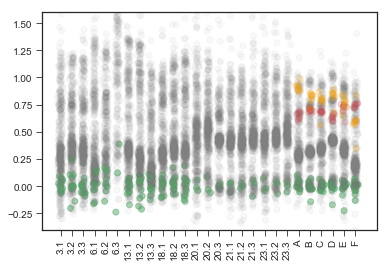

In [52]:
data = merged_data
data = data[~(merged_data['barcode'].isin([7777777,9999999]))]
data = data.sort_values('barcode')

spike_in_missense = [9000000 + i for i in range(11)]
spike_in_nonsense = [9000100 + i for i in range(11)]
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

neutrals = [bc for bc in data['barcode'].values if bc in neutrals]
# neutrals = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]
neutral_locs = np.where(np.isin(data['barcode'].values,neutrals))[0]
color_set = []
alphas = []
for bc in data['barcode'].values:
#     print(bc)
    if bc in spike_in_missense:
        color_set.append(colors.to_rgba('r',0.2))
    elif bc in spike_in_nonsense:
        color_set.append(colors.to_rgba('orange',0.2))
    elif bc in neutrals:
        color_set.append(colors.to_rgba('g',0.5))
    elif bc == 9999999:
        color_set.append(colors.to_rgba('k',0.5))
    else:
        color_set.append(colors.to_rgba('gray',0.05))



for j,condition in enumerate(just_reps):
    plt.scatter([jitter_point(j,0.1) for  i in range(len(fitnesses[f'{condition}_fitness']))],fitnesses[f'{condition}_fitness'],color=color_set)

plt.xticks(range(len(just_reps)),just_reps,rotation=90)
plt.ylim(-0.4,1.6)
# plt.savefig('AllM3_conditions_fitness_allTPs.png',bbox_inches='tight',dpi=300)

(-0.4, 1.6)

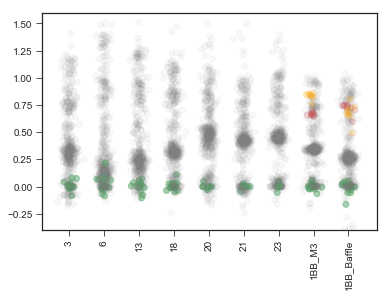

In [105]:
data = merged_data
data = data[~(merged_data['barcode'].isin([7777777,9999999]))]
data = data.sort_values('barcode')

spike_in_missense = [9000000 + i for i in range(11)]
spike_in_nonsense = [9000100 + i for i in range(11)]
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

neutrals = [bc for bc in data['barcode'].values if bc in neutrals]
# neutrals = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]
neutral_locs = np.where(np.isin(data['barcode'].values,neutrals))[0]
color_set = []
alphas = []
for bc in data['barcode'].values:
#     print(bc)
    if bc in spike_in_missense:
        color_set.append(colors.to_rgba('r',0.2))
    elif bc in spike_in_nonsense:
        color_set.append(colors.to_rgba('orange',0.2))
    elif bc in neutrals:
        color_set.append(colors.to_rgba('g',0.5))
    elif bc == 9999999:
        color_set.append(colors.to_rgba('k',0.5))
    else:
        color_set.append(colors.to_rgba('gray',0.05))



for j,condition in enumerate(conditions.keys()):
    plt.scatter([jitter_point(j,0.1) for  i in range(len(fitness_df[f'{condition}_fitness'].values))],fitness_df[f'{condition}_fitness'].values,color=color_set)

plt.xticks(range(len(conditions.keys())),conditions.keys(),rotation=90)
plt.ylim(-0.4,1.6)
# plt.savefig('AllM3_conditions_fitness_allTPs.png',bbox_inches='tight',dpi=300)